## HW2: Interpretable Machine Learning with Bankruptcy Prediction

### Setup

In [62]:
# if any of the following packages are missing, please install them before proceeding
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import shap
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

from sklearn.model_selection import cross_val_score, GridSearchCV


In [2]:
# load data and partition into train and test sets
# please run the following code exactly to ensure reproducibility
data = pd.read_csv("bankruptcy.csv")
Y = data["D"]
X = data.drop(columns=["D"])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
# this cell should return (105, 24) (105,) (27, 24) (27,)

(105, 24) (105,) (27, 24) (27,)


### Model 1: Decision Tree

##### Model Train & Evaluation

In [64]:
cv_scores = cross_val_score(dtree, X_train, Y_train, cv=5, scoring='roc_auc')
print("CV ROC-AUC:", cv_scores.mean(), "+-", cv_scores.std())


CV ROC-AUC: 0.7630808080808082 +- 0.09483288562680406


In [66]:
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 8, 10, None],
    'min_samples_split': [2, 4, 6, 8, 10]
}

clf = GridSearchCV(dtree, param_grid, cv=5, scoring='roc_auc')
clf.fit(X_train, Y_train)
print("Best params:", clf.best_params_)
print("Best CV ROC-AUC:", clf.best_score_)


Best params: {'max_depth': 2, 'min_samples_split': 2}
Best CV ROC-AUC: 0.8646296296296295


Test ROC-AUC (class 1): 0.8271604938271605
Classification Report (focus on class 1):
              precision    recall  f1-score   support

           0      0.789     0.833     0.811        18
           1      0.625     0.556     0.588         9

    accuracy                          0.741        27
   macro avg      0.707     0.694     0.700        27
weighted avg      0.735     0.741     0.737        27



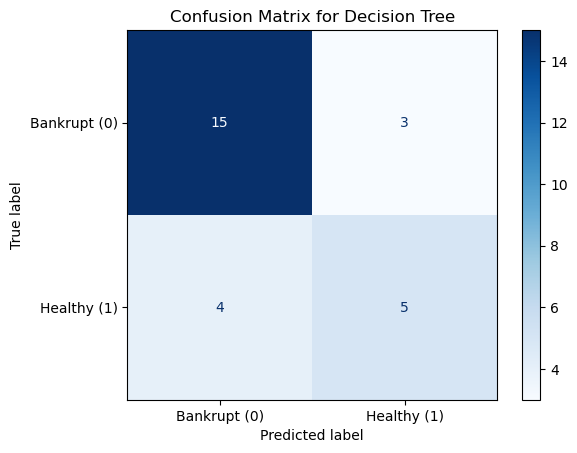

In [80]:
# Get the best estimator (model with best params, refit on all X_train)
dtree = clf.best_estimator_

# Predict on test set
Y_pred_dtree = dtree.predict(X_test)
Y_prob_dtree = dtree.predict_proba(X_test)[:, 1]  # Probability for class 1
# ROC-AUC (focuses on ability to distinguish class 1)
roc_auc = roc_auc_score(Y_test, Y_prob_dtree)
print("Test ROC-AUC (class 1):", roc_auc)

# Performance report
print("Classification Report (focus on class 1):")
print(classification_report(Y_test, Y_pred_dtree, digits=3))
# Compute confusion matrix
cm_tree= confusion_matrix(Y_test, Y_pred_dtree)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=["Bankrupt (0)", "Healthy (1)"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Decision Tree")
plt.show()


##### Global Interpretation—Which Ratios Matter Most?

R24: 0.714
R21: 0.151
R13: 0.135
R11: 0.000
R2: 0.000
R3: 0.000
R4: 0.000
R5: 0.000
R6: 0.000
R7: 0.000


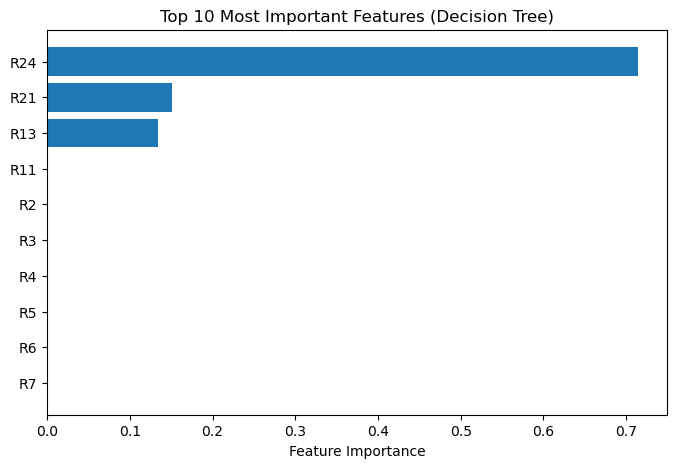

In [76]:
# Get feature importances
importances = dtree.feature_importances_
features = X_train.columns
indices = np.argsort(importances)[::-1]

# Print top 10 features
for idx in indices[:10]:
    print(f"{features[idx]}: {importances[idx]:.3f}")

# Bar plot of importances
plt.figure(figsize=(8,5))
plt.barh(features[indices][:10][::-1], importances[indices][:10][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 10 Most Important Features (Decision Tree)")
plt.show()


##### Decision Tree - Global Interpretation:
The tuned decision tree’s predictions are dominated by just a few financial ratios. 
- The **most influential ratio is R24 (WCFO/DEBTS), which accounts for over 70 percent of the model’s decision process**.
- R21 (ASSETS/DEBTS) and R13 (INC/SALES) also contribute, but to a much lesser extent.
- Most other ratios have little to no importance in the final model, reflecting the tree’s very shallow structure.

Note:
*In the untuned decision tree, feature importances were much more spread out across a wider range of ratios. Hyperparameter tuning led the model to rely heavily on just a few highly predictive features, making the tuned model both simpler and more focused.* (Insight from trial versions)

### Model 2: Random Forest

##### Model Train & Evaluation

In [82]:
rf = RandomForestClassifier(random_state=42, n_estimators=100)
cv_scores = cross_val_score(rf, X_train, Y_train, cv=5, scoring='roc_auc')
print("CV ROC-AUC:", cv_scores.mean(), "+-", cv_scores.std())


CV ROC-AUC: 0.904175084175084 +- 0.07259853067546818


In [92]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 4, None],
    'min_samples_split': [2, 4]}
clf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='roc_auc')
clf.fit(X_train, Y_train)
rf = clf.best_estimator_

print("Best params:", clf.best_params_)
print("Best CV ROC-AUC:", clf.best_score_)
# Predict on test set
Y_pred = rf.predict(X_test)
Y_prob = rf.predict_proba(X_test)[:, 1]  # Probability for class 1 ("healthy")

Best params: {'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best CV ROC-AUC: 0.9134343434343435


Classification Report (focus on class 1):
              precision    recall  f1-score   support

           0      0.938     0.833     0.882        18
           1      0.727     0.889     0.800         9

    accuracy                          0.852        27
   macro avg      0.832     0.861     0.841        27
weighted avg      0.867     0.852     0.855        27

Test ROC-AUC (class 1): 0.8950617283950617


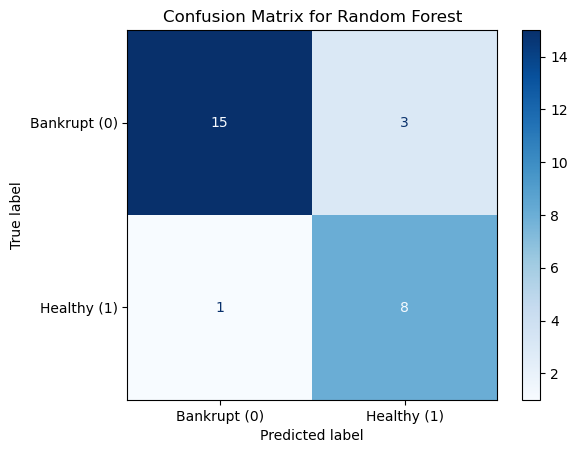

In [94]:
# Performance report
print("Classification Report (focus on class 1):")
print(classification_report(Y_test, Y_pred, digits=3))

# ROC-AUC
roc_auc = roc_auc_score(Y_test, Y_prob)
print("Test ROC-AUC (class 1):", roc_auc)

# Confusion Matrix Plot
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Bankrupt (0)", "Healthy (1)"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Random Forest")
plt.show()


R18: 0.108
R21: 0.106
R14: 0.100
R24: 0.091
R15: 0.076
R17: 0.063
R9: 0.057
R23: 0.057
R13: 0.039
R4: 0.030


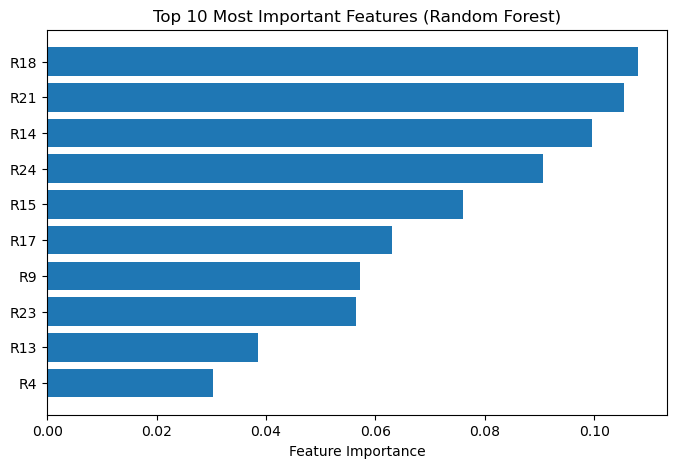

In [133]:
# Get feature importances
importances = rf.feature_importances_
features = X_train.columns
indices = np.argsort(importances)[::-1]

# Print top 10 features
for idx in indices[:10]:
    print(f"{features[idx]}: {importances[idx]:.3f}")

# Bar plot of importances
plt.figure(figsize=(8,5))
plt.barh(features[indices][:10][::-1], importances[indices][:10][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 10 Most Important Features (Random Forest)")
plt.show()


#####  Random Forest - Global Interpretation:
- The random forest model **identifies R18 (INCDEP/DEBTS), R21 (ASSETS/DEBTS), and R14 (INC/ASSETS) as the most influential financial ratios for predicting bankruptcy risk**. 
- These top features reflect a company’s ability to cover its debts through income and assets, as well as operational strength.
- Other important contributors include R24 (WCFO/DEBTS), R15 (INC/DEBTS), and several measures related to cash flow and receivables, showing the model considers multiple aspects of financial health.
- This distribution of importance indicates that the model relies on a well-rounded view of leverage, income generation, and liquidity when assessing bankruptcy risk.

### Model 3: SHAP

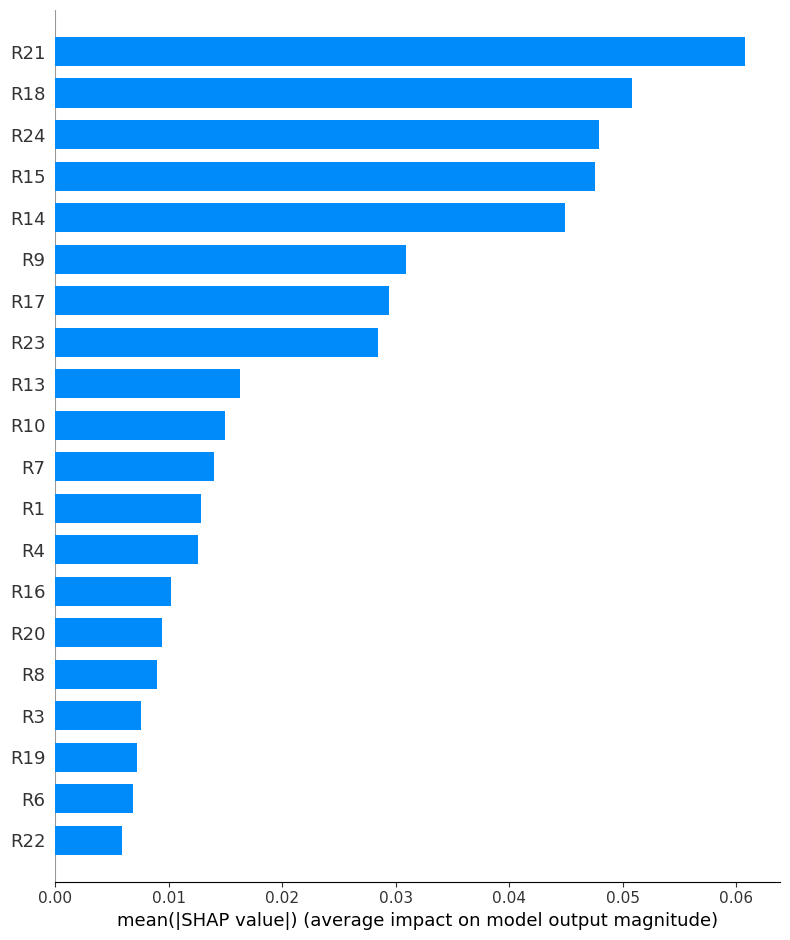

In [96]:
# Use SHAP to explain your random forest model's predictions on the test set. Report global interpretation (i.e., you will need to aggregate SHAP values across all test samples in some way)
# Use TreeExplainer (it is designed to explain tree ensemble models), documentation here: https://shap.readthedocs.io/en/latest/generated/shap.TreeExplainer.html

# 1. Create the SHAP TreeExplainer for your trained Random Forest model
explainer = shap.TreeExplainer(rf)  # rf is your trained RandomForestClassifier

# 2. Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)  # shape: (n_samples, n_features, 2)

# 3. Focus on SHAP values for class 1 ("healthy")
shap_values_class1 = shap_values[:, :, 1]  # shape: (n_samples, n_features)
shap.summary_plot(shap_values_class1, X_test, plot_type="bar", show=True)


  0%|          | 0/27 [00:00<?, ?it/s]

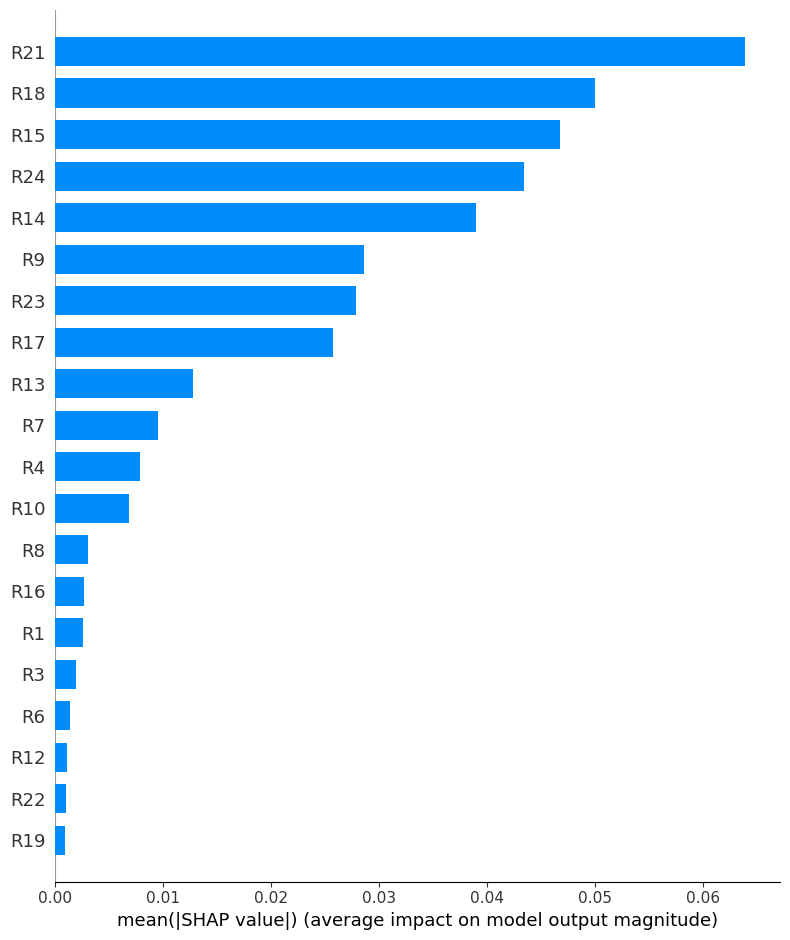

In [98]:
# Now use a different SHAP explainer, such as KernelExplainer: https://shap.readthedocs.io/en/latest/generated/shap.KernelExplainer.html
# Report global interpretation 
def rf_predict_proba(X):
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X, columns=X_train.columns)
    return rf.predict_proba(X)[:, 1]

# 2. Select a small background sample from your training data for efficiency
background = X_train.sample(n=20, random_state=42)  # Already a DataFrame

# 3. Create the KernelExplainer
explainer_kernel = shap.KernelExplainer(rf_predict_proba, background)
shap_values_kernel = explainer_kernel.shap_values(X_test, nsamples=100)

# 5. Global interpretation: mean absolute SHAP value bar plot
shap.summary_plot(shap_values_kernel, X_test, plot_type="bar", show=True)



### Global Interpretation: Random Forest Model

#### A. SHAP TreeExplainer

- **Most influential features:**
    - R21 (ASSETS/DEBTS)
    - R18 (INCDEP/DEBTS)
    - R24 (WCFO/DEBTS)
    - R15 (INC/DEBTS)
    - R14 (INC/ASSETS)
- **Interpretation:**  
  TreeExplainer shows that the model’s predictions are strongly driven by leverage, income relative to debts, and operational cash flow.

---

#### B. SHAP KernelExplainer

- **Most influential features:**
    - R21 (ASSETS/DEBTS)
    - R18 (INCDEP/DEBTS)
    - R24 (WCFO/DEBTS)
    - R15 (INC/DEBTS)
    - R9 (CURASS/CURDEBT) and R14 (INC/ASSETS) with moderate influence
- **Interpretation:**  
  KernelExplainer also highlights the same top features—leverage, cash flow, and profitability—though it may attribute slightly more importance to secondary ratios like R9 and R14.


### Consistency Across Interpretation Methods

- Both the TreeExplainer and KernelExplainer SHAP analyses provide highly consistent results, identifying the same core financial ratios (R21, R18, R24, and R15) as the primary drivers of the model’s bankruptcy risk predictions.
- The exact ranking and the relative importance of secondary features (like R14, R9, or R23) does vary slightly. These minor differences are expected due to the inherent differences in how each method attributes importance
**The overall insights about which financial indicators matter most remain robust and unchanged across methods.This consistency reinforces the reliability and transparency of the model’s explanations.**



### Executive Summary


Our bankruptcy prediction model was analyzed using two advanced interpretation approaches: SHAP TreeExplainer and SHAP KernelExplainer. Both techniques independently confirm that the model relies on the same core financial health indicators when making its prediction.

#### Key Ratios Consistently Identified

- **Assets to Debts (R21):** Central to evaluating a company’s leverage and long-term stability.
- **Income plus Depreciation to Debts (R18):** Reflects the ability to meet obligations from core business earnings.
- **Working Capital from Operations to Debts (R24):** Highlights how well a company can cover debt through regular operations.
- **Income to Debts (R15) and Income to Assets (R14):** Signal profitability and the efficiency of asset use.
- **Current Assets to Current Debt (R9):** Occasionally emphasized, further supporting the importance of liquidity


Both interpretive methods reveal a clear pattern: the model’s risk assessments are shaped by a firm’s leverage, income generation, and operational cash flow. The consistency between approaches gives us added confidence in the transparency and stability of our risk scoring.


#### What This Means for Decision-Making

The repeated emphasis on these financial ratios means our risk model not only aligns with sound business principles but also provides reliable and actionable signals for leadership. This supports more confident prioritization of client engagements, risk reviews and strategic planning

### Business Recommendations

Based on the bankruptcy prediction model’s consistent emphasis on leverage, cash flow, and profitability ratios, the following actions are recommended for companies aiming to reduce financial risk and strengthen long-term stability:


#### 1. Strengthen Balance Sheet Leverage

- **Monitor and Manage Debt Levels:**  
  Regularly assess the company’s assets-to-debts (R21) and income-to-debts (R15) ratios. Set internal thresholds and early warning triggers for when these ratios approach risk zones.
- **Consider Debt Restructuring:**  
  For firms with high leverage, explore refinancing options, negotiate better terms with creditors, or prioritize debt repayment to bring leverage within safe bounds.


#### 2. Enhance Operational Cash Flow

- **Improve Cash Flow from Operations:**  
  Focus on increasing working capital from operations relative to debts (R24). Implement tighter cash management practices, accelerate receivables, and optimize inventory levels to ensure steady operational cash flow.
- **Expense Control:**  
  Review operational expenses and seek cost efficiencies that directly impact the company’s ability to service debt from core activities.



#### 3. Boost Profitability and Income Generation

- **Increase Earnings Quality:**  
  Work to improve the income-to-assets (R14) and income plus depreciation-to-debts (R18) ratios by driving revenue growth and controlling asset-related costs.
- **Asset Utilization:**  
  Evaluate underperforming assets and consider divestment or repurposing to improve overall returns.


#### 4. Proactive Risk Monitoring and Early Intervention

- **Implement Real-Time Ratio Tracking:**  
  Deploy dashboards to continuously monitor the key financial ratios highlighted by the model. Automated alerts can help management take timely action as soon as warning signs emerge.
- **Regular Financial Health Reviews:**  
  Schedule periodic reviews focused on these ratios to keep risk management at the forefront of executive discussions.



**Summary:**  
By prioritizing improvements in leverage, cash flow, and profitability ratios—and closely monitoring these areas—companies can significantly reduce their bankruptcy risk and build a more resilient financial future.
